Exploring, cleaning, and wrangling just the numerical ratings from the MUBI database.

#### Imports

In [3]:
%load_ext sql
%sql sqlite:///Data//mubi_db.sqlite

In [4]:
from sqlalchemy import create_engine
conn = create_engine('sqlite:///Data//mubi_db.sqlite').connect()

In [5]:
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

In [6]:
from itertools import chain
def flatten(list_of_lists):
    "Flatten one level of nesting"
    return chain.from_iterable(list_of_lists)

#### Grab the data and import it into a dataframe

In [7]:
q = "SELECT movie_id, rating_score, user_id FROM ratings;"
df = pd.read_sql_query(q, conn)

In [8]:
#Some people write reviews but don't give a numerical rating. 
#These are kept in the databse but I don't need them for now.
df.dropna(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15493274 entries, 0 to 15520004
Data columns (total 3 columns):
 #   Column        Dtype  
---  ------        -----  
 0   movie_id      int64  
 1   rating_score  float64
 2   user_id       int64  
dtypes: float64(1), int64(2)
memory usage: 472.8 MB


In [10]:
#reduce memory load of the dataframe
df['rating_score'] = df['rating_score'].astype('int8')
df['movie_id'] = df['movie_id'].astype('int32')
df['user_id'] = df['user_id'].astype('int32')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15493274 entries, 0 to 15520004
Data columns (total 3 columns):
 #   Column        Dtype
---  ------        -----
 0   movie_id      int32
 1   rating_score  int8 
 2   user_id       int32
dtypes: int32(2), int8(1)
memory usage: 251.2 MB


#### Look at users

There are almost 450k unique users. the vast majority of them only have 1-2 ratings in the system. Some of them have 10s of thousands of ratings. I probably don't need to keep the extremes of these ranges on either end. 

In [12]:
sorted_users = df.groupby('user_id').count()['rating_score'].sort_values(ascending=False)
sorted_users

user_id
12295046    19983
2591449     17053
24226320    11183
35097747    11158
92027428    10544
            ...  
46061762        1
46062167        1
46062375        1
46062569        1
99999860        1
Name: rating_score, Length: 448627, dtype: int64

In [13]:
np.quantile(sorted_users.values, [.7, .8, .9, .99])

array([  5.  ,  11.  ,  41.  , 695.74])

In [14]:
n_movies = len(df.movie_id.unique())
n_movies

142606

I can do a comparison of how limiting the number of users via number of ratings will affect the number of unique movies in the reuslting dataset. I don't want to lose too many movies, but I also can't run the analyses on ALL this data. 

In [37]:
def percent_movies_kept(rating_percentile_range=(.5, .99), n_movies=n_movies):
    '''
    takes two percentiles (lower and upper bound), and the number of unique movies in the dataset.
    returns the percentage of movies that will be kept if number of ratings is limited to the percentile ranges set.
    also returns the length of the resulting dataframe (in long form)
    '''
    
    upper = np.ceil(np.quantile(sorted_users.values, rating_percentile_range[1]))
    lower = np.ceil(np.quantile(sorted_users.values, rating_percentile_range[0]))
    
    temp_users = sorted_users[(sorted_users.values<=upper)&(sorted_users.values>=lower)].index
    movies_kept = df[df.user_id.isin(temp_users)]
    
    p_movies_kept = len(movies_kept.movie_id.unique()) / n_movies
    
    return p_movies_kept, len(movies_kept)

In [43]:
upper_ranges = [.9, .92, .95, .97, .99]
lower_ranges = [.4, .5, .6, .7, .75]

In [44]:
range_combos = ((l,u) for l in lower_ranges for u in upper_ranges)

percents = []
for combo in range_combos:
    p, l = percent_movies_kept(rating_percentile_range=combo)
    percents.append((combo[0], combo[1], p, l))

In [45]:
percents_df = pd.DataFrame(index = lower_ranges, columns=upper_ranges)
for p in percents:
    percents_df.at[p[0], p[1]] = p[2]

In [46]:
percents_df

,0.90,0.92,0.95,0.97,0.99
0.40,0.269869,0.29578,0.354389,0.425796,0.590361
0.50,0.234527,0.263972,0.328254,0.40452,0.576175
0.60,0.224079,0.254982,0.321389,0.399331,0.572928
0.70,0.212726,0.245445,0.314489,0.394338,0.570011
0.75,0.201268,0.236294,0.308185,0.389731,0.567374


In [51]:
longform_percents_df = pd.DataFrame(columns = ["lower", "upper", "percent", "df_len"], data = percents)

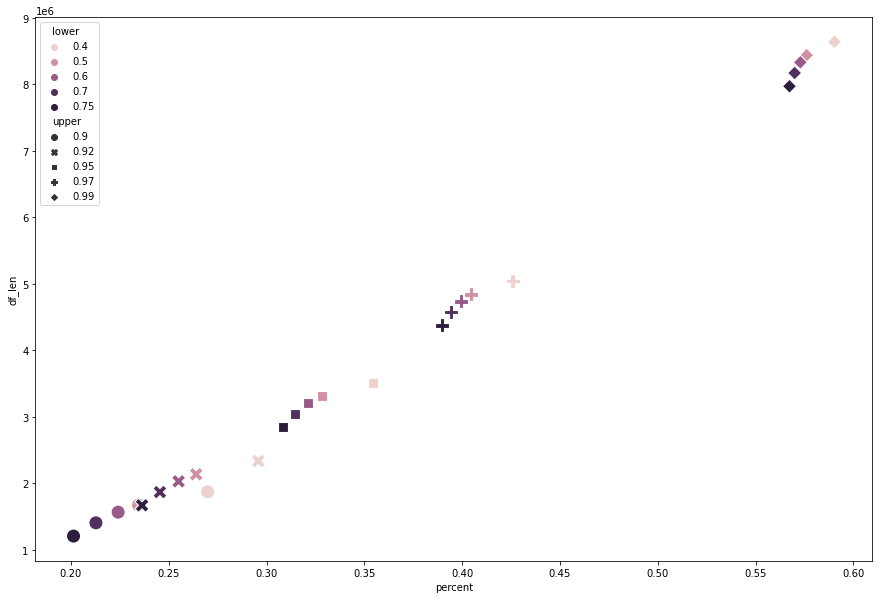

In [62]:
fig, ax = plt.subplots(figsize=(15,10))

sns.scatterplot(data = longform_percents_df, 
                x='percent', y='df_len',
               hue = 'lower',
               style = 'upper',
               s=200)
plt.show()

This is interesting but I do need the keep the business case in mind here. Having ready recommendations for users who have rated 100s, if not 1000s of movies is definitely desireable, but it's going to lead to better customer retention to be able to recommend movies to users with very few ratings. Enticing newer customers to stay is always a harder task than keeping long-standing customers (though long standing customers are obviously still very important!)

So let's look at the actual numbers these percentiles represent. 

In [65]:
np.quantile(sorted_users.values, [.4, .5, .6, .7, .75, .99])

array([  1.  ,   2.  ,   3.  ,   5.  ,   8.  , 695.74])

It does not seem unreasonable to ask new members to rate at least 5 movies upon signing up if they want to take advantage of the recommender system. However, can we go lower than the 99th percentile (almost 700 ratings) while not losing too many unique movies in our list?

In [66]:
upper_ranges = [.975, .98, .985, .99]
lower_ranges = [.7]

range_combos = ((l,u) for l in lower_ranges for u in upper_ranges)

percents = []
for combo in range_combos:
    p, l = percent_movies_kept(rating_percentile_range=combo)
    percents.append((combo[0], combo[1], p, l))

In [67]:
longform_percents_df = pd.DataFrame(columns = ["lower", "upper", "percent", "df_len"], data = percents)

In [73]:
longform_percents_df

,lower,upper,percent,df_len
0,0.7,0.975,0.424470,5171865
1,0.7,0.980,0.464700,5914822
2,0.7,0.985,0.509102,6864260
3,0.7,0.990,0.570011,8168743


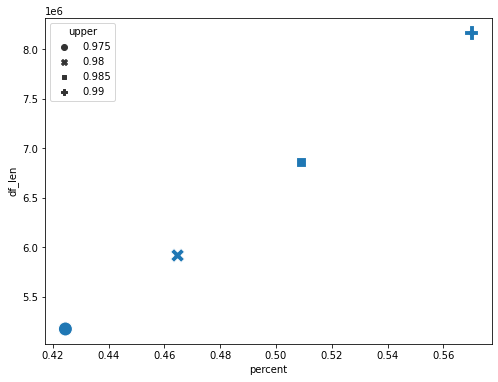

In [70]:
fig, ax = plt.subplots(figsize=(8,6))

sns.scatterplot(data = longform_percents_df, 
                x='percent', y='df_len',
#                hue = 'lower',
               style = 'upper',
               s=200)
plt.show()

In [74]:
#unique movies kept if I put threshold at 99th percentile of ratings
n_movies * .57

81285.42

In [78]:
#unique movies kept if I put threshold at 98.5th percentile of ratings
n_movies * .51

72729.06

In [79]:
#rating ranges to be kept
np.quantile(sorted_users.values, [.7, .985])

array([  5., 490.])

losing 1/2 a percent (~700 movies) of total unique movies but having over a million fewer entries in the dataframe seems like a legitimate tradeoff. 

#### Create dataframe of "moderate" users

In [15]:
moderate_users = sorted_users[(sorted_users.values<=1000)&(sorted_users.values>=20)].index

In [16]:
df_moderate = df[df.user_id.isin(moderate_users)]

In [17]:
df_moderate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8854093 entries, 0 to 15520003
Data columns (total 3 columns):
 #   Column        Dtype
---  ------        -----
 0   movie_id      int32
 1   rating_score  int8 
 2   user_id       int32
dtypes: int32(2), int8(1)
memory usage: 143.5 MB


In [18]:
df_moderate.groupby('rating_score').count()['user_id']

rating_score
1     319847
2     803974
3    2225980
4    3222211
5    2282081
Name: user_id, dtype: int64

In [19]:
df_moderate.head()

,movie_id,rating_score,user_id
0,1066,3,41579158
4,1066,4,68654088
5,1066,4,97262846
7,1066,3,57756708
8,1066,4,58420503


#### Generate some basic stats for these moderate users.

In [20]:
moderate_user_stats = pd.DataFrame(columns = ['mean_score', 'median_score', 'n_ratings'])
moderate_user_stats['mean_score'] = df_moderate.groupby('user_id').mean()['rating_score']
moderate_user_stats['median_score'] = df_moderate.groupby('user_id').median()['rating_score']
moderate_user_stats['n_ratings'] = df_moderate.groupby('user_id').count()['rating_score']

In [21]:
moderate_user_stats

,mean_score,median_score,n_ratings
user_id,,,
7952,4.516129,5.0,31
12546,3.430108,3.0,186
13000,3.219178,3.0,219
14464,3.585000,4.0,600
14730,4.175000,4.0,40
...,...,...,...
99989323,3.782051,4.0,78
99991548,3.600000,4.0,25
99993564,4.233438,5.0,317


In [22]:
pd.to_pickle(df_moderate, "./Data/reviews_20_1000_longform.pkl")
pd.to_pickle(moderate_user_stats, "./Data/users_20_1000_stats.pkl")

This dataset is still far too large to pivot. I will have to take a subsample of it. 

a total of 250k rows seems to be the upper limit for the machine I'm working on. Since I'm subsampling anyway, I'll do an even selection across ratings. 

In [89]:
keepers = []
for rating in df_moderate.rating_score.unique():
    temp_df = df_moderate[df_moderate.rating_score==rating]
    keepers.append(random.choices(temp_df.index, k=50000))
    
keepers = list(flatten(keepers))

In [91]:
smaller_selection = df_moderate.loc[keepers].reset_index(drop=True)

In [92]:
smaller_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   movie_id      250000 non-null  int32
 1   rating_score  250000 non-null  int8 
 2   user_id       250000 non-null  int32
dtypes: int32(2), int8(1)
memory usage: 2.1 MB


In [93]:
selection_pivot = smaller_selection.pivot_table(index='movie_id', columns='user_id', values='rating_score')

In [94]:
selection_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23279 entries, 1 to 263673
Columns: 68261 entries, 176 to 99999515
dtypes: float64(68261)
memory usage: 11.8 GB


In [95]:
pd.to_pickle(selection_pivot, "./Data/even_selection_50k_pivot.pkl")

In [96]:
#oops, should have swapped the index and columns in the pivot creation
selection_pivot = selection_pivot.T

#### Center data around 0 and fill in missing values

In [100]:
#take the overall mean scores of the users who are in this subselected table
moderate_user_stats.loc[selection_pivot.index]['mean_score']

user_id
176         3.538462
7952        4.516129
11142       2.857143
12546       3.430108
13000       3.219178
              ...   
99991548    3.600000
99993564    4.233438
99996903    3.650794
99997323    3.970109
99999515    4.000000
Name: mean_score, Length: 68261, dtype: float64

In [101]:
#subtract these values from the pivot table to center everything around 0
user_ratings_centered = selection_pivot.sub(moderate_user_stats.loc[selection_pivot.index]['mean_score'], 
                                            axis=0)

In [102]:
#fill in the Nans with 0s, now that everything is centered. 
user_ratings_centered.fillna(0, inplace=True)

In [103]:
user_ratings_centered.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,259238,259539,259542,259643,259786,260373,260892,261372,261524,263673
user_id,,,,,,,,,,,,,,,,,,,,,
176,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
pd.to_pickle(user_ratings_centered, "./Data/user_ratings_centered.pkl")

#### Make an even smaller subselection to test and explore various models

In [106]:
keepers = []
for rating in df_moderate.rating_score.unique():
    temp_df = df_moderate[df_moderate.rating_score==rating]
    keepers.append(random.choices(temp_df.index, k=5000))
    
keepers = list(flatten(keepers))

In [107]:
smaller_selection = df_moderate.loc[keepers].reset_index(drop=True)

In [108]:
smaller_selection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   movie_id      25000 non-null  int32
 1   rating_score  25000 non-null  int8 
 2   user_id       25000 non-null  int32
dtypes: int32(2), int8(1)
memory usage: 219.9 KB


In [109]:
selection_pivot = smaller_selection.pivot_table(index='movie_id', columns='user_id', values='rating_score')

In [110]:
selection_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7816 entries, 2 to 261824
Columns: 17923 entries, 13000 to 99997323
dtypes: float64(17923)
memory usage: 1.0 GB


In [111]:
pd.to_pickle(selection_pivot, "./Data/even_selection_5k_pivot.pkl")